# Locality-Sensitive Hashing and Functions

Prepared by: Norbert Paul R. Gerena

In [1]:
import matplotlib.pyplot as plt
import numpy as np

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-emq7ypn6 because the default path (/home/ngerena/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Flow of Discussion

1. Introduction and Motivation to LSH
2. Review of hashing and MinHash Signature Matrix
3. LSH for Jaccard Distance
4. Generalizing LSH
6. Putting it all together
5. Applications

## I. Introduction

In this notebook, we will be discussing Locality-Sensitive Hashing (LSH) and its applications.

**Why do we want locality**

A lot of applications in data science require a notion of distance and similarity. Here are some examples:
 * Clustering
 * Information retrieval
 

**Why not just compute similarity as needed?**

If we have n documents to compare, then it would take us $n \choose 2$ pairwise evaluation of distances. If we have massive amount of documents, we do not want to evaluate the distances of all pairs, we want to have some sort of "initial filtering" of potentially similar documents.

**Why use hashing?**

We only have to do hashing once. It can add to the overhead but it can make things more efficient later on since it can speed up the search.

## II. Review of Hashing and MinHash Signature Matrix

### Hashing

A hash function is any function that can be used to map data of arbitrary size to fixed-size values. In the context of LSH, a hash function takes two sets, $x$ and $y$, and returns a decision whether these two sets are candidate for comparison.

### MinHash Signature Matrix

Jaccard Sim (shingles) $\approx$ Hamming Sim (signature matrix). The Hamming similarity of a two vectors is the proportion of equal components of the vectors.

## III. LSH for Jaccard Distance (Using the MinHash Signature Matrix) 

**General Idea:** For a huge set of elements, we do not want to evaluate the similarity of every pair of elements. Our goal for LSH is to generate from these collection of elements, a small list of potentially similar pairs or candidate pairs. We can then evaluate the similarity of these candidate pairs.

### LSH for MinHash Signature Matrix

1. Divide the signature matrix $M$ into $b$ bands and $r$ rows per band.

![](images/lsh1.png)

2. Per band, apply a hash function. We can use the same hash function for all bands but each band must have its own hash table.

![](images/lsh2.png)

3. Candidate column pairs are those that hash to the same bucket for $\ge$ 1 band

**Let's look at the math of the LSH function described above**

1. Let's assume that columns $C_1$ and $C_2$ have similarity $s$.
2. The probability that row n of $C_1$ and row n of $C_2$ are equal is approximately $s$, since we are dealing with the MinHash Signature.
3. Within a band, the probability that all rows are equal is $s^r$. Conversely, the probability that some rows are not equal is $1-s^r$.
4. The probability that no bands are identical is $(1-s^r)^b$
5. Finally, the probability that at least 1 band is identical is $1-(1-s^r)^b$

Let's look at the characteristics of this function.

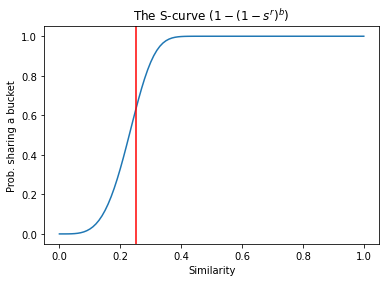

In [77]:
#relationship of r and b to the s-curve
r = 4
b = 250

def sfunc(x, r, b):
    return 1 - (1-x**r)**b

xs = np.arange(0,1.01, 0.01)
ys = list(map(lambda x: sfunc(x, r, b), xs))
plt.plot(xs, ys)
plt.title('The S-curve ($1-(1-s^r)^b$)');
plt.xlabel('Similarity')
plt.ylabel('Prob. sharing a bucket')

t = (1/b)**(1/r) #the treshold depends on b and r
plt.axvline(t, c='r');

If the size of the signature matrix is fixed we can find the combination of r and b such that the similarity threshold $t$ is near $(1/b)^{(1/r)}$. We can make this lower than $t$ if we want to reduce the false negatives. Note that this can increase the false positives, hence we have to evaluate more pairs.

* Larger $r$ means we want higher similarity
* Lager $b$ means a higher  chance that a pair will be a candidate pair

### The Ideal S-Curve

![](images/idealcurve.png)

We want a steep S-curve!

## IV. General LSH

The procedure described in the previous section is not the only LSH function. 

Can we use different similarity metric asside from Jaccard?

Can we apply OR on rows first then AND on buckets?

Yes, we can generalize LSH!

### LSH Families of Hash Functions

Again, hash functions in the context of LSH is bit different.

An LSH hash function takes two sets, $x$ and $y$, and returns a decision whether these two sets are candidate for comparison.

For example, given a set of minhash functions $h$, we can have a simple LSH function such that if $h(x)=h(y)$, then $x$ and $y$ are candidate pairs.

We will use this shorthand $h(x)=h(y)$, to mean that "h says yes".
#### LSH Family Definition

Suppose we have a metric space with a set of points $S$ and a distance metric $d$.

A family $H$ of hash functions is said to be $(d_1, d_2, p_1, p_2)$-sensitive if for any points $x,y \in S$:

1. If $d(x,y)\le d_1$, then the probability over all $h$ in $H$, that $h(x)=h(y)$ is at least $p_1$.
2. If $d(x,y)\ge d_2$, then the probability over all $h$ in $H$, that $h(x)=h(y)$ is at most $p_2$.

Note that $d_1 < d_2$.

![](images/generalcurve.png)

* We want $d_1$ and $d_2$ to be as close as possible while maintaining a big gap in $p_1$ and $p_2$.

**Let's look at the LSH-Family using Jaccard Distance**

For a set of points S and d equal to the Jaccard distance. We can construct a family of minhash functions $H$ consisting of all permutations, such that $H$ is a $(d_1, d_2,1-d_1, 1-d_2)$-sensitive family for S and d.

This LSH family will not give us the ideal curve. 

Why?

### Amplifying the S-Curve

Recall our shorthand, $h(x)=h(y)$. We can make the definition of LSH family more general by making this definition more flexible.

For example we can have an **AND-construction** from the original set $H$ to generate a new family $H'$:

1. Suppose $H$ consists of $\{h_1, h_2, h_3, ...\}$, we can construct $H'=\{ h'_1, h'_2, h'_3,...\}$, such that $h' = \{ h_1,...,h_r\}$.
2. Now, $h'(x)=h'(y)$ if and only if $h_i(x)=h_i(y)$ for all $i$.

What's the sensitivity of $H'$?

$(d_1, d_2, (1-d_1)^r, (1-d_2)^r)$

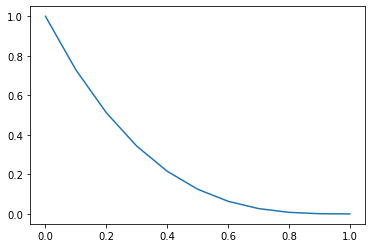

In [79]:
r = 3
xs = np.arange(0,1.01,0.1)
ys = list(map(lambda x: (1-x)**r,xs))
plt.plot(xs,ys);

* The **AND-construction** makes the probability of $d_2$ closer to zero. Meaning, we are reducing the false positives.
* Tweak $r$ such that the the desired $d_2$ will have a very small probability

**OR-Construction**

1. Suppose $H$ consists of $\{h_1, h_2, h_3, ...\}$, we can construct $H'=\{ h'_1, h'_2, h'_3,...\}$, such that $h' = \{ h_1,...,h_b\}$.
2. Now, $h'(x)=h'(y)$ if and only if $h_i(x)=h_i(y)$ for for at least 1 $i$.

What's the sensitivity of $H'$?

$(d_1, d_2, 1-(d_1)^b, 1-(d_2)^b)$

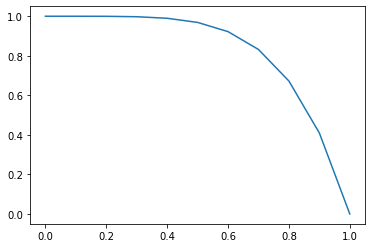

In [13]:
b = 5
xs = np.arange(0,1.01,0.1)
ys = list(map(lambda x: 1-x**b,xs))
plt.plot(xs,ys);

* The **OR-construction** makes the probability of $d_1$ closer to 1. Meaning, we are decreasing the false negatives.
* Tweak $b$ such that the the desired $d_1$ will have a very high probability

### Composing Constructions

The **AND-construction** and the **OR-construction** by themselves can not give us the ideal S-curve that we want. We can compose an **AND-OR construction** as described in the **LSH for MinHash Signature Matrix** example.

In that example, we were able to create a LSH Family with a sensitivity of $(d_1, d_2, 1-(1-(1-d_1)^r)^b, 1-(1-(1-d_2)^r)^b)$

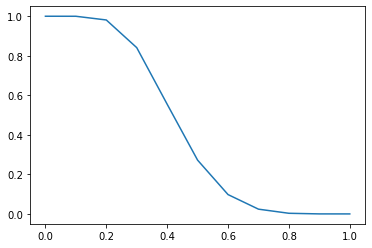

In [14]:
r= 5
b = 10
xs = np.arange(0,1.01,0.1)
ys = list(map(lambda x: 1-(1-(1-x)**r)**b,xs))
plt.plot(xs,ys);

* We can make the S-curve even better by cascading the constructions. However this means more memory usage since we need to construct more hash tables.

### LSH Families for Other Distance Metrics

So far we have constructed several LSH Families from the family of MinHash functions (which approximates the Jaccard distance).

How can we construct a family of hash functions for other distance metrics?

#### Review of Distance Metrics

Definition:

Suppose with have a space $S$, consisting of points. The distance measure is $d(x,y)$ takes two points, $x,y \in S$ and produces a real number and satisfies the following:

1. $d(x,y) \ge 0$ 
2. $d(x,y) = 0$ if and only if $x=y$
3. $d(x,y) = d(y,x)$
4. $d(x,y) \le d(x,z) + d(z,y)$ 

**Examples**

1. Euclidean distance
2. Cosine distance
3. Hamming distance

#### LSH for Euclidean Distance

**Goal:** Create a hash function that will be applied per element. After the hashing, the elements that are potentially similar, with respect to the chosen distance metric, will be in the same bucket of the hash table.

**Hash function via projection into a random line**

Consider the simple 2-D case.

![](images/euclsh.png)

* The hash function $h$ is constructed by creating a random line in space with a predefined bucket width $a$.
* A point will be stored in the bucket where it was projected on the random line.
* Given a set of hash functions (each with $a$ and random line equation), this is an LSH family with $ (a/2, 2a, 1/2, 1/3)$-sensitivity.
* We can again apply **AND-OR** construction to improve the S-curve.

Can you think of hash function for Hamming distance?

## V. Putting it all together

![](images/bigpic.png)

* Depending on the desired distance metric, hashing can be done via:
    * MinHashing for Jaccard distance
    * Random line projection and bucketing for Euclidean distance
    * Random hyperplanes projection/sketches for Cosine distance
    
* Applying these hash functions will usually result in signatures that are shorter in length than the original matrix.
* Using these hash functions alone will usually not give us the ideal S-curve
* To improve the s-curve we can construct a new family of hash functions via the composition and cascading of **AND-construction** and **OR-construction** until we are satisfied with its sensitivity.
* We can stop with the resulting candidate pairs or we can evaluate their similarity to filter our target documents.

## VI. Application of LSH

In this section, we will be implementing MinHash LSH using Python and Spark. There are two methods that can be used depending on the size of the documents. These are the two cases:

1. Each document can fit to memory
2. Each document or some documents can not fit to memory

The gutenberg project dataset will be used in this demonstration.

In [2]:
#for tokenization
from nltk.tokenize import word_tokenize

In [4]:
from pyspark import SparkContext

sc = SparkContext()

23/02/10 14:45:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [37]:
#read some of the files
texts = (sc.wholeTextFiles('/mnt/data/public/gutenberg/1/1/*/*/*/?????.txt'))

In [38]:
#check for the numberof documents
texts.count()

867

The following code implements a pseudo-permutation via random hashing as described in the book [1]. The simplest way to create random hash is to concatenate a random string, "salt" in this case, and a number string ("0", "1", ..., or "n") to the original element or word. We can then use Python's hash module to transform the resulting text into an integer, which we can interpret as the the word's new index after the permutation.

Note that in this implementation, we do not need to know the whole corpus of words or tokens. As long as we are consistent with the hash functions, we just need to apply the hash functions per document.

In [7]:
#some codes from https://github.com/go2starr/lshhdc

from collections import defaultdict


class Signature(object):
    """Signature Base class."""

    def __init__(self, dim):
        self.dim = dim
        self.hashes = self.hash_functions()

    def hash_functions(self):
        """Returns dim different hash functions"""
        pass

    def sign(self, object):
        """Return the signature for object s"""
        pass


class MinHashSignature(Signature):
    """Creates signatures for sets/tuples using minhash."""

    def hash_functions(self):
        """Return dim different hash functions"""
        def hash_factory(n):
            return lambda x: hash("salt" + str(n) + str(x) + "salt")
        return [ hash_factory(_) for _ in range(self.dim) ]

    def sign(self, s):
        """Returns minhash signature for set s"""
        sig = [ float("inf") ] * self.dim
        for hash_ix, hash_fn in enumerate(self.hashes):
            sig[hash_ix] = min(hash_fn(value) for value in s)
        return sig

### Case 1: Each document can fit to memory

Since each document can fit to a node's memory, its word tokens can also fit. In this case, we can represent our data as *(document_id, text)*. Then we can immediately use the **MinHashSignature** class above to the tokenized text *(document_id, tokens)*.

We will be using a Min-hash signature of size 100.

In [39]:
sig = MinHashSignature(100)
minHashed = texts.mapValues(lambda s: word_tokenize(s)).mapValues(lambda s: sig.sign(s))
minHashed.collect()

Exception in thread "serve RDD 75" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


[('file:/mnt/data/public/gutenberg/1/1/0/0/11003/11003.txt',
  [-9219924115034153262,
   -9214922226085548855,
   -9219712593560867474,
   -9219181810807693989,
   -9222472235967190823,
   -9213169527573432578,
   -9220291695656885971,
   -9220664476194896576,
   -9220844780731228826,
   -9215275951366796618,
   -9222487069767655407,
   -9211237510043629656,
   -9221061475765578039,
   -9217586351887871034,
   -9221310223570030495,
   -9214129564653638048,
   -9223007396866433476,
   -9212105028624787235,
   -9214171796177656955,
   -9217637076268477730,
   -9216042639710824780,
   -9219279619155355157,
   -9219323209234205953,
   -9221616563024713569,
   -9213529970842944010,
   -9219115980407456210,
   -9222995114070260496,
   -9218977503555833018,
   -9221703265933214790,
   -9221507977235220003,
   -9209477517330609174,
   -9220081835358281037,
   -9217270340098007816,
   -9222495242340051900,
   -9204796379568900011,
   -9218127912331916087,
   -9216884946752394407,
   -9218741419

### Case 2: Each document or some documents can not fit to memory

Another case is when the documents can not fit to memory, hence we can not represent our data as *(document_id, text)*. We can instead represent it as  *(document_id, sub_text)* then to *(document_id, token_a)*. We can now apply the hash functions to each individual token. However, we need to take note of the hash function used for each *(document_id, token_a)*. We can do this by adding a hash_function_id to the resulting hashed token: *((document_id, hash_function_id), hashed_token_a)*.

We can now find the minimum *hash_token_a* per *hash_function_id* via reduction by key, with key as *(document_id, hash_function_id)*.

In [40]:
file_ngram = texts.mapValues(lambda s: word_tokenize(s)).flatMap(lambda x: [(x[0], i) for i in x[1]])
def hash_functions(word, n):
    
    hashed = []
    for n in range(n):
        hash_fn = lambda x: hash("salt" + str(n) + str(x) + "salt")
        hashed.append((n, hash_fn(word)))
    return hashed

file_hash = (file_ngram.mapValues(lambda x: hash_functions(x, 100))
             .flatMap(lambda x: [((x[0], i[0]), i[1]) for i in x[1]]))
minHashed = (file_hash.reduceByKey(lambda x, y: x if x<y else y)
             .map(lambda x: (x[0][0], [(x[0][1], x[1])]))
             .reduceByKey(lambda x,y: x+y))
minHashed.take(10)

[('file:/mnt/data/public/gutenberg/1/1/0/0/11003/11003.txt',
  [(0, -9219924115034153262),
   (2, -9219712593560867474),
   (4, -9222472235967190823),
   (6, -9220291695656885971),
   (8, -9220844780731228826),
   (10, -9222487069767655407),
   (12, -9221061475765578039),
   (14, -9221310223570030495),
   (16, -9223007396866433476),
   (18, -9214171796177656955),
   (20, -9216042639710824780),
   (22, -9219323209234205953),
   (24, -9213529970842944010),
   (26, -9222995114070260496),
   (28, -9221703265933214790),
   (30, -9209477517330609174),
   (32, -9217270340098007816),
   (34, -9204796379568900011),
   (36, -9216884946752394407),
   (38, -9212768976525199466),
   (40, -9218372434166300109),
   (42, -9220755927080166502),
   (44, -9222850378789218211),
   (46, -9220490302045510903),
   (48, -9218699356302876107),
   (50, -9218694138191171792),
   (52, -9216465147763101260),
   (54, -9220708589155750388),
   (56, -9220844364303518997),
   (58, -9221155687864975590),
   (60, -92178

Note that this is much slower than the Case 1 approach.

The next step is to perform the banding technique discussed in the previous sections. To do this we simply hash the set of hash values in a band, thereby, reducing the number of dimensions. Let's call this a *hashed-band*.

In [225]:
def hash_per_band(sig, b):
    hashed = []
    for band in zip(*(iter(sig),) * b):
        hashed.append(hash(band))
    return hashed

hashed_per_band = minHashed.mapValues(lambda sig: hash_per_band(sig,4))
hashed_per_band.take(1)

[('file:/mnt/data/public/gutenberg/1/1/1/0/11100/11100.txt',
  [-1924275899946411142,
   5543244265878867294,
   -8821916905136539093,
   8025132904793161215,
   -4491693916500386011,
   7225620602243390950,
   6278862911897480642,
   5703536231261297067,
   4343715519722334528,
   -8528561963276481359,
   3395996876261406367,
   240098548252534138,
   -263975870605852516,
   -8621529406472440154,
   -1792285223418787760,
   -1228530806977869070,
   -8227588960051929810,
   -8761154491639846629,
   -5833796065310335206,
   5368479758661758014,
   -6281925384922071815,
   3188210969908710248,
   -6255188373741880750,
   -6229827228889285217,
   -3313987983763965792])]

To know which set of documents are bucketed together, we just need to collect documents with similar *hashed-bands*.

In [226]:
#make the hashed bands as keys then reduce
(hashed_per_band.flatMap(lambda x: [(h, [x[0]]) for h in x[1]])
 .reduceByKey(lambda x,y: x+y).filter(lambda x: len(x[1]) > 2).take(10))

[(7709525042361206601,
  ['file:/mnt/data/public/gutenberg/1/1/1/0/11103/11103.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/1/11117/11117.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/5/11155/11155.txt']),
 (-3477787748629620043,
  ['file:/mnt/data/public/gutenberg/1/1/1/0/11103/11103.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/4/11141/11141.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/7/11173/11173.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/8/11180/11180.txt']),
 (-5102229227738459110,
  ['file:/mnt/data/public/gutenberg/1/1/1/0/11105/11105.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/2/11127/11127.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/6/11162/11162.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/8/11182/11182.txt']),
 (6235679427626599058,
  ['file:/mnt/data/public/gutenberg/1/1/1/0/11105/11105.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/8/11186/11186.txt',
   'file:/mnt/data/public/gutenberg/1/1/1/8/11187/11187.txt']),
 (3393452311701492771,
  ['fil

The result above are some of the buckets with at least 2 documents in it. Let's look at the actual similarity of some of the document-pair inside a bucket.

In [242]:
def jaccard(u,v):
    return len(set(u).intersection(v))/len(set(u).union(v))

In [245]:
def jaccard_files(f1, f2):
    with open(f1) as file1:
        text1 = file1.read()
    with open(f2) as file2:
        text2 = file2.read()
    
    ngram1 = word_tokenize(text1)
    ngram2  = word_tokenize(text2)
    return jaccard(ngram1, ngram2)

In [250]:
jaccard_files('/mnt/data/public/gutenberg/1/1/1/0/11105/11105.txt', '/mnt/data/public/gutenberg/1/1/1/6/11162/11162.txt')

0.6110800223838836

The sample document-pair above has an actual Jaccard similarity of 0.6.

## References

1. Jure Leskovec , Anand Rajaraman, and Jeffrey D Ullman. *Mining of massive datasets*.Cambridge university press, 3rd edition, 2019. URL http://www.mmds.org/, chapter 3.

2. Jure Leskovec , Anand Rajaraman, and Jeffrey D Ullman, *Finding Similar Items: Locality Sensitive Hashing* [PowerPoint slides]. http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf.